In [66]:
import gym
import gym.wrappers
import numpy as np
import logging
import joblib
import matplotlib.pylab as pl
import threading
%matplotlib inline

from tqdm import tqdm_notebook as tqdm

In [67]:
gym.logger.setLevel(logging.ERROR)
env = gym.make("LunarLander-v2")
env = gym.wrappers.Monitor(env, "lunarlander-res")
monitor_mode = True
n_actions = env.action_space.n

print("n_actions=%i" % (n_actions))

n_actions=4


In [68]:
from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(128,128),
                      activation='tanh',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1 #make only 1 iteration on each .fit(...)
                     )
#initialize agent to the dimension of state an amount of actions
agent.fit([env.reset()]*n_actions,range(n_actions));

/home/shmuma/anaconda3/envs/pract_rl/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


In [69]:
def generate_session(t_max=10000):
    if monitor_mode:
        global env
        e = env
    else:
        loc_data = threading.local()
        if not hasattr(loc_data, "env"):
            loc_data.env = gym.make("LunarLander-v2")
        e = loc_data.env
        
    states, actions = [], []
    total_reward = 0
    s = e.reset()
    
    for _ in range(t_max):
        probs = agent.predict_proba([s])[0]
        a = np.random.choice(n_actions, p=probs)
        new_s, r, done, _ = e.step(a)
        states.append(s)
        actions.append(a)
        total_reward += r
        s = new_s
        if done:
            break
    
    return states, actions, total_reward

In [70]:
n_jobs = 4
n_samples = 250
percentile = 50
rewards = []
thresholds = []
finetune_mode = False

In [79]:
for i in range(500):
    # it's essential to create new pool of workers every time
    #%time 
    if monitor_mode:
        sessions = [generate_session() for _ in range(n_samples)]
    else:
        sessions = joblib.Parallel(n_jobs)(joblib.delayed(generate_session)() for _ in range(n_samples))
    batch_states, batch_actions, batch_rewards = map(np.array, zip(*sessions))

    threshold = np.percentile(batch_rewards, percentile)
    elite_states = batch_states[batch_rewards > threshold]
    elite_actions = batch_actions[batch_rewards > threshold]

    if not elite_states.size:
        print("%d: no elite sessions, try again" % i)
        continue

    elite_states, elite_actions = map(np.concatenate, [elite_states, elite_actions])

    agent.fit(elite_states, elite_actions)
    print("%d: mean reward = %.5f (max: %f)\tthreshold = %.1f" % (
        i, np.mean(batch_rewards), np.max(batch_rewards), threshold))
    thresholds.append(threshold)
    rewards.append(np.mean(batch_rewards))
    
    if not finetune_mode and np.mean(batch_rewards) > -50:
        finetune_mode = True
        percentile = 65 # was 75
        n_samples = 500
        print("Finetune mode activated")

0: mean reward = 70.97224 (max: 258.918510)	threshold = 168.4
1: mean reward = 68.85615 (max: 255.178423)	threshold = 168.5
2: mean reward = 74.92321 (max: 246.000137)	threshold = 173.5
3: mean reward = 75.09922 (max: 250.732590)	threshold = 178.3
4: mean reward = 78.81934 (max: 256.459451)	threshold = 178.4
5: mean reward = 74.20325 (max: 254.300270)	threshold = 173.9
6: mean reward = 83.33514 (max: 248.144070)	threshold = 177.0
7: mean reward = 80.17887 (max: 244.487048)	threshold = 182.6
8: mean reward = 77.26912 (max: 246.733808)	threshold = 182.6
9: mean reward = 83.86009 (max: 266.839370)	threshold = 179.7
10: mean reward = 82.69809 (max: 247.702966)	threshold = 183.3
11: mean reward = 77.20096 (max: 253.972052)	threshold = 189.0
12: mean reward = 89.67991 (max: 245.408175)	threshold = 186.1
13: mean reward = 78.94764 (max: 252.617881)	threshold = 188.7
14: mean reward = 85.93394 (max: 246.846261)	threshold = 186.6
15: mean reward = 94.47342 (max: 251.620445)	threshold = 185.7
16

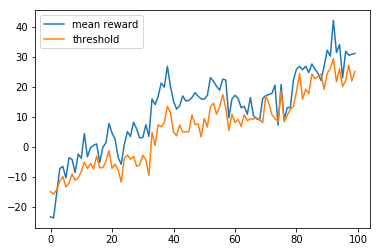

In [75]:
pl.plot(rewards, label='mean reward')
pl.plot(thresholds, label='threshold')
pl.legend()
pl.show()

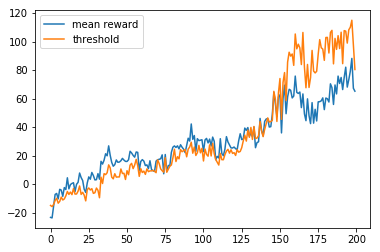

In [77]:
pl.plot(rewards, label='mean reward')
pl.plot(thresholds, label='threshold')
pl.legend()
pl.show()

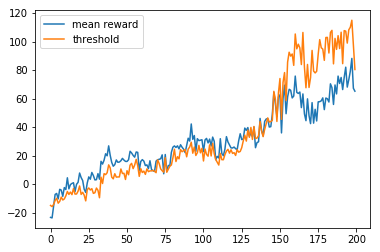

In [77]:
pl.plot(rewards, label='mean reward')
pl.plot(thresholds, label='threshold')
pl.legend()
pl.show()